In [1]:
%matplotlib inline
import os
import gzip
import pickle
import glob
import datetime
import warnings

from multiprocessing import Pool

import netCDF4
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

warnings.simplefilter("ignore")

In [2]:
def read_data(infile="CPOL_RCA_1998-2017.pkl.gz"):
    """
    Read pickle data file containing the RCA values.
    
    Parameter:
    ==========
    infile: str
        Input file name.
        
    Returns:
    ========
    rca: ndarray
        The 95th percentile of the clutter reflectivity distribution
    dtime: ndarray
        The datetime of the corresponding rca values.
    """
    with gzip.GzipFile(infile, "r") as gzid:
        data = pickle.load(gzid)
        rca = data['RCA']
        dtime = data['dtime']
        
    return rca, dtime

In [3]:
def rca_mean_distribution(rca, dtime):
    """
    Transforms the datetime and rca arrays into a panda dataframe. 
    Two dataframe are generated, ones containing the 10 min values 
    and another one containing a daily mean value. Values are corrected 
    from theirs offset and scale_factors (cause RAPIC format sucks.)
    
    Parameters:
    ===========
    rca: ndarray
        The 95th percentile of the clutter reflectivity distribution
    dtime: ndarray
        The datetime of the corresponding rca values.
        
    Returns:
    ========
    my_rca_hourly: Dataframe
        Dataframe of the RCA values for each scan.
    my_rca_daily: Dataframe
        Dataframe of the daily RCA.
    """
    pos = ((dtime >= datetime.datetime(2009, 1, 1)) & (dtime <= datetime.datetime(2015, 10, 1))) | ((dtime >= datetime.datetime(2016, 10, 1)) & (dtime <= datetime.datetime(2017, 10, 1)))
    myrca = rca
    myrca[pos] = myrca[pos] / 2 - 32
    
    df = pd.Series(data=rca, index=dtime)            
        
    my_rca_hourly = df.resample('20Min').mean()
    my_rca_daily = df.resample('1D').mean()
    
    return my_rca_hourly, my_rca_daily

In [4]:
def make_rca_plot(val_rcah, val_rcad, rca, time_hourly, time_daily, dtime, year, lbound, ubound, saverage=None, method=False, save=False):
    """
    Plot RCA 3 pannels figure.
    
    Parameters:
    ===========
    
    """
    st = datetime.datetime(year, 10, 1)
    ed = datetime.datetime(year + 1, 5, 1)
    fpos = lambda x: (x > st) & (x < ed)

    posh = fpos(time_hourly)
    posd = fpos(time_daily)
    posi = fpos(dtime)    

    x0 = time_hourly[posh]
    y0 = val_rcah[posh]
    x1 = time_daily[posd]
    y1 = val_rcad[posd]
    
    if len(x0) == 0:
        print("No data")
        return None
    
    count = len(rca[posi])
    count_d = len(y1)
    
    avg = y1[~np.isnan(y1)]
    
    if saverage is None:
        saverage = np.median(avg)
            
    sstdi = np.nanstd(y0[(x0 > datetime.datetime(year + 1, 1, 1))])
    
    try:
        lb = np.percentile(y1[~np.isnan(y1)], 0.01)
        ub = np.percentile(y1[~np.isnan(y1)], 0.99)
    except IndexError:
        return None
    sstdd = np.nanstd(y1[(x1 > datetime.datetime(year + 1, 1, 1))])

    pos = ~np.isnan(y1)
    xp = x1[pos]
    yp = y1[pos]
    
    if method:
        drca = saverage - yp
    else:
        drca = np.diff(yp)
        drca = np.append(drca, [np.NaN])
        
    greater_than_threshold = [i for i, val in enumerate(drca) if (val >= 0.5) | (val <= -0.5)]
    
    width = 5.5
    height = width/1.3333

    with pl.style.context('seaborn-paper'):
        fig, myax = pl.subplots(3, 1, sharex=True) #, figsize=(12, 10))

        myax[0].plot(x0, y0, '.', label="10 min (%i scans)" % (count))
        myax[0].plot([x1[0], x1[-1]], [saverage, saverage], 'k--', label="$ \overline{Z_c}[ref.] = %0.1f \pm %0.2f $ dBZ" % (saverage, sstdi))
        myax[0].set_ylim(lbound, ubound)
        myax[0].set_ylabel(r"$CDF_{95} \left[Z_c \right]$ (dB)")
        myax[0].text(x1[5], ubound - 1, "a)", va='top', ha='left', fontsize='large')
        myax[0].set_title("CPOL - season %i/%i." % (year, year + 1))

        myax[1].plot(x1, y1, '.', label="Daily mean (%i days)" % (count_d))
        myax[1].plot([x1[0], x1[-1]], [saverage, saverage], 'k--', label="$ \overline{Z_c}[ref.] = %0.1f \pm %0.2f $ dBZ" % (saverage, sstdd))
        myax[1].set_ylim(lbound, ubound)
        myax[1].set_ylabel(r"$\overline{CDF_{95}} \left[Z_c \right]$ (dB)")
        myax[1].text(x1[5], ubound - 1, "b)", va='top', ha='left', fontsize='large')

        myax[2].plot(xp, drca, '.', label="Daily mean")
        myax[2].plot(xp[greater_than_threshold], drca[greater_than_threshold], 'ro', label="Calibration change")
        myax[2].plot([st, ed], [-0.5, -0.5], "r:")
        myax[2].plot([st, ed], [0.5, 0.5], "r:")
        myax[2].set_ylim(-2., 2.)
        myax[2].set_ylabel(r"RCA offset (dB)")
        myax[2].text(x1[5], 1.8, "c)", va='top', ha='left', fontsize='large')    

        for lax in myax:
            lax.set_xlim(st, ed)
            lax.legend(loc=1)
            lax.grid()

        fig.autofmt_xdate()
        fig.tight_layout()
        fig.set_size_inches(width, height)
        if save:
            pl.savefig("CPOL_s%i%i.png" % (year, year + 1), dpi=600)            
            pl.savefig("CPOL_s%i%i.pdf" % (year, year + 1))            
        else:
            pl.show()
        
    return saverage, sstdi, sstdd

In [5]:
rca, dtime = read_data()
rca_hourly, rca_daily = rca_mean_distribution(rca, dtime)
time_hourly = rca_hourly.index
val_rcah = rca_hourly.values    
time_daily = rca_daily.index
val_rcad = rca_daily.values

In [9]:
rca_daily[(rca_daily.index >= datetime.datetime(2006, 1, 1)) & (rca_daily.index <= datetime.datetime(2006, 1, 31))].describe()

count    31.000000
mean     66.024831
std       0.416062
min      65.272569
25%      65.736979
50%      66.137674
75%      66.352778
max      66.543576
dtype: float64

In [36]:
66.3-2.7

63.599999999999994

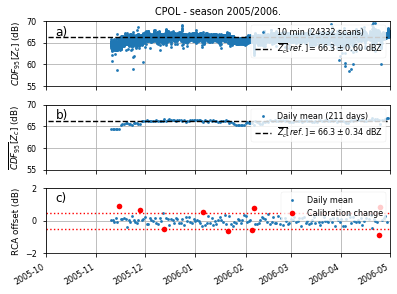

In [11]:
out = [make_rca_plot(val_rcah, val_rcad, rca, time_hourly, time_daily, dtime, y, 55, 70, save=True) for y in [2005]]

In [8]:
out

[(47.72388887209592, 0.1620370586634843, 0.032596593919484926)]

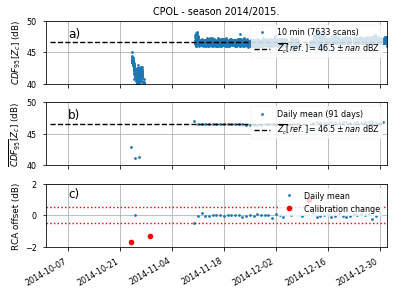

In [10]:
out =  [make_rca_plot(val_rcah, val_rcad, rca, time_hourly, time_daily, dtime, y, 40, 50) for y in [2014]] 

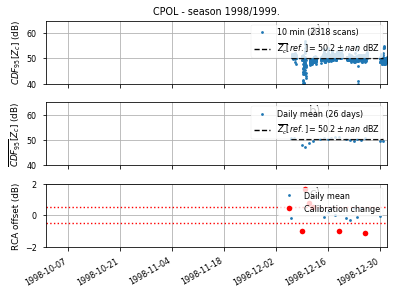

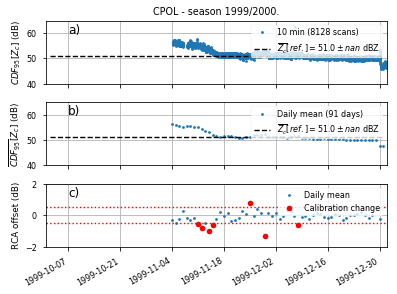

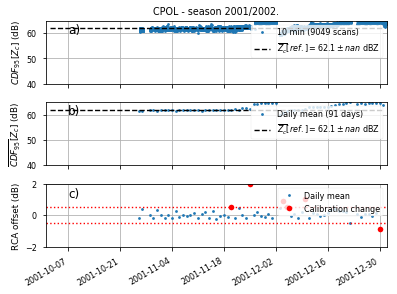

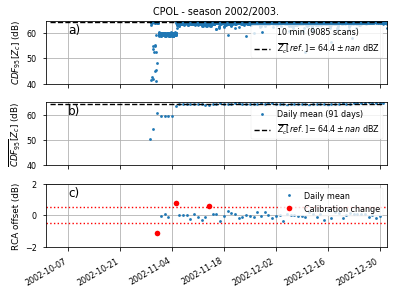

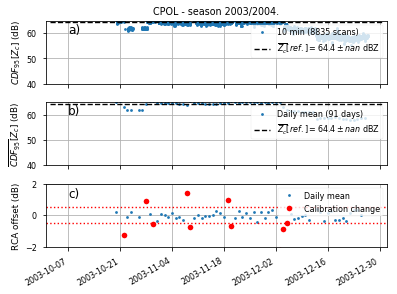

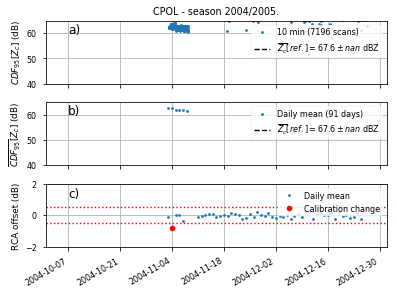

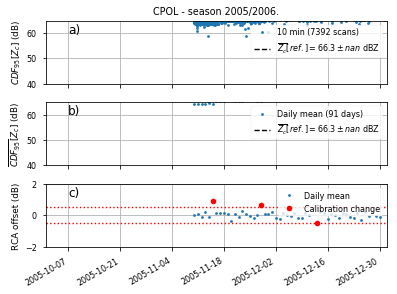

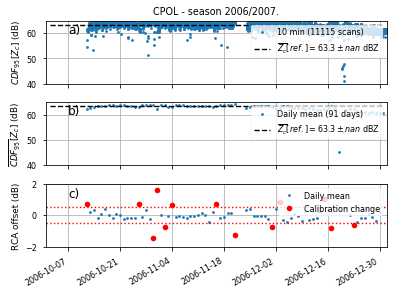

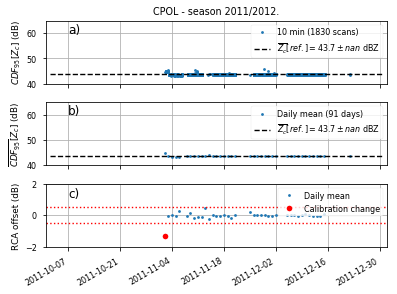

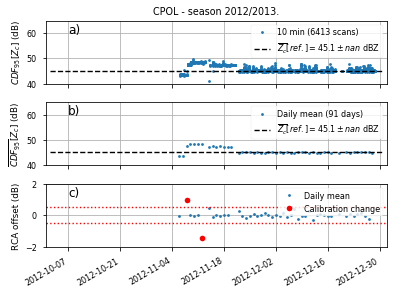

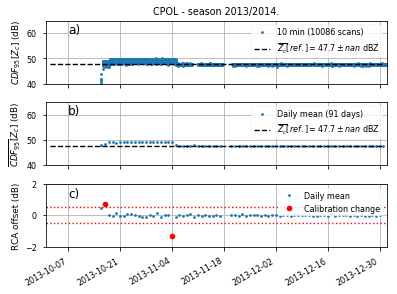

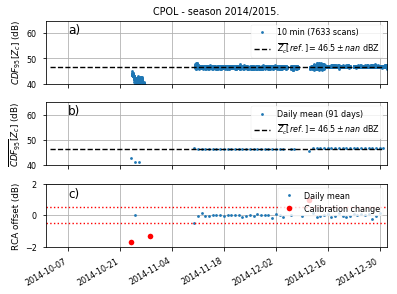

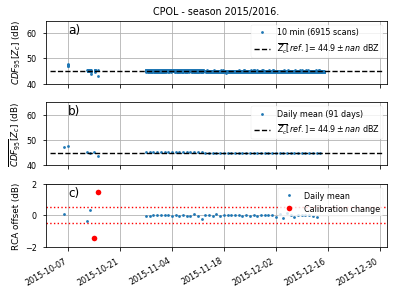

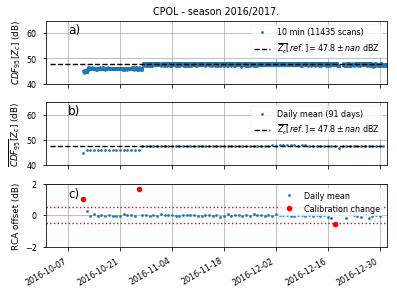

In [11]:
out = [make_rca_plot(val_rcah, val_rcad, rca, time_hourly, time_daily, dtime, y, 40, 65) for y in range(1998, 2017)]

# Old RCA data.

In [42]:
ncid = netCDF4.Dataset("/home/548/vhl548/test_data/RCA_CPOL_2014-01-31T00:00:05_to_2014-01-31T23:50:11.nc", "r")

In [43]:
rca = ncid["rca"][:]
time = ncid["time"][:]
rain = ncid["rain"][:]

In [44]:
ncid.close()

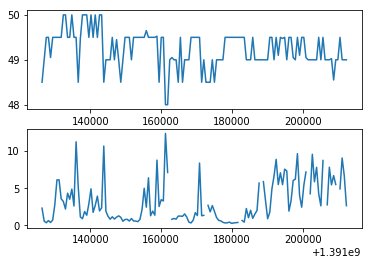

In [47]:
pl.subplot(2, 1, 1)
pl.plot(time, rca)
pl.subplot(2, 1, 2)
pl.plot(time, rain)
pl.show()

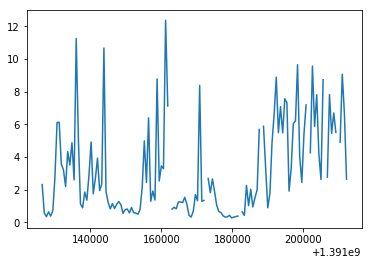